### Что узнала про астроциты, нейроны и tripartite synapse.

Астроциты - это многоотросчатые клетки нейроглии. Отростки некоторых астроцитов формируют пограничную глиальную мембрану на внутренней (желудочковой) или наружной (пиальной) поверхности мозга. Другие астроцитарные отростки принимают участие в образовании межнейрональных синапсов. Кроме того, сосудистые отростки астроцитов участвуют в формировании капилляров мозга.

Нейрон - электрически возбудимая клетка, которая предназначена для приёма извне, обработки, хранения, передачи и вывода вовне информации с помощью электрических и химических сигналов. Типичный нейрон состоит из тела клетки, дендритов и одного аксона.

Трёхстронний синапс - это функциональная интеграция и физическая близость пресинаптической мембраны, постсинаптической мембраны и их тесная связь с окружающими глиальными клетками - совместное участие трёх компонентов в производстве активности в химическом синапсе.

### Код

In [247]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [267]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
from PIL import Image

In [268]:
import openpyxl

### Функции для чтения данных

In [269]:
def create_folders_lists(main_path):
    event_folders = []
    activity_folders = []
    folder_names = []
    for folder_name in os.listdir(main_path):
        folder_names.append(folder_name)
        folder_path = os.path.join(main_path, folder_name)
        subfolders = os.listdir(folder_path)
        event_folder_path = os.path.join(folder_path, subfolders[0])
        activity_folder_path = os.path.join(folder_path, subfolders[1])

        event_folders.append(event_folder_path)
        activity_folders.append(activity_folder_path)

    return event_folders, activity_folders, folder_names

In [270]:
def create_dataframe(folder, name_dataset):
    data = []
    image_names = natsorted(os.listdir(folder))  
    for image_name in image_names:
        image_path = os.path.join(folder, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_data = {
            'dataset': name_dataset,
            'image_name': image_name,
            'image_path': image_path,
            'image_size': image.shape}
        data.append(image_data)
    df = pd.DataFrame(data)
    return df

### 6.3 Посчитать среднюю площадь области в зависимости от времени.

In [271]:
def find_count_white_areas(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    white_areas_count = 0
    total_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        white_areas_count += 1
        total_area += area
    spatial_scale = 5.1
    if white_areas_count > 0:
        avg_area_in_mkm = total_area / (white_areas_count * (spatial_scale ** 2)) 
    else:
        avg_area_in_mkm = 0
    return white_areas_count, avg_area_in_mkm

In [272]:
def adding_information_about_white_areas(df):
    white_areas_count = []
    average_areas = []
    for image_path in df['image_path']:
        result_function_1 = find_count_white_areas(image_path)  
        white_areas_count.append(result_function_1[0])
        average_areas.append(result_function_1[1])
    df['white_areas_count'] = white_areas_count
    df['average_area'] = average_areas
    return df

In [273]:
def graph_average_area(df):
    df['time_seconds'] = df.index / 2
    time = df['time_seconds']
    average_area = df['average_area']
    gragh = plt.figure(figsize = (6.7, 3.11), dpi = 300)   
    plt.plot(time, average_area, color = 'limegreen', linewidth = 3)
    plt.xlabel('Время, c')
    plt.ylabel('Средняя площадь области, мкм²')
    plt.title('Средняя площадь области кальциевого \n события в зависимости от времени')
    plt.xlim(df['time_seconds'].min(), df['time_seconds'].max())
    plt.ylim(df['average_area'].min(), df['average_area'].max())
    plt.legend()
    plt.tight_layout()
    plt.show()
    return gragh

In [274]:
def save_graph(gragh, name_graph_png, name_graph_svg):
    gragh.savefig(name_graph_png)
    gragh.savefig(name_graph_svg)

In [275]:
def save_data_average_area(df, name_table):
    time_average_area_df = df[['time_seconds', 'average_area']].copy()
    print(time_average_area_df)
    time_average_area_df.to_excel(name_table)

### 6.6 Построить двумерную гистограмму: для каждого пикселя количество моментов времени, когда он начинал гореть (то есть смена значения пикселя с 0 на 1).

In [276]:
def count_burning_times(df):
    image = cv2.imread(df['image_path'][0],cv2.IMREAD_GRAYSCALE)
    burning_times = np.zeros_like(image)
    for i in df.index:
        if i < len(df.index) - 1:
            image = cv2.imread(df['image_path'][i],cv2.IMREAD_GRAYSCALE)
            next_image = cv2.imread(df['image_path'][i+1],cv2.IMREAD_GRAYSCALE)
            if image.size == next_image.size:
                x1, y1 = image.shape
                for x in range(0, x1):
                    for y in range(0, y1):
                        if image[x, y] == 0 and next_image[x, y] == 255:
                            burning_times[x,y] += 1
    return burning_times


In [277]:
def getting_a_histogramm(burning_times):
    sh = burning_times.shape
    my_x = sh[1]
    hist = plt.figure() 
    plt.pcolormesh(burning_times, cmap = 'inferno')
    plt.colorbar  
    plt.axis("scaled")
    plt.title('Количество моментов времени,\n когда пиксель начинал гореть')
    x_scale = [my_x - 70, my_x - 19]
    y_scale = [5, 5]
    plt.plot(x_scale, y_scale, linewidth = 3)
    plt.text(my_x - 45, 10, '10 мкм', va = 'bottom', ha = 'center', color = 'white')
    plt.show()
    return hist

In [278]:
def save_histogramm(hist, name_hist_png, name_hist_svg):
    hist.savefig(name_hist_png)
    hist.savefig(name_hist_svg)

### 6.8 Найти число: средний уровень светимости внутри кальциевого события, усреднение по всем кадрам.

In [279]:
def crop_image(activ, event):
    difer_in_width = int(abs(activ.shape[0] - event.shape[0])/2)
    difer_in_hight = int(abs(activ.shape[1] - event.shape[1])/2)
    if activ.size > event.size:
        cropped = activ[difer_in_width: - difer_in_width, difer_in_hight: - difer_in_hight]
    else:
        cropped = event[difer_in_width: - difer_in_width, difer_in_hight: - difer_in_hight]
    return cropped

In [280]:
def luminosity_level(event_df, activity_df):
    luminosity = []
    for i in event_df.index:
        if i < len(event_df.index) - 1:
            event = cv2.imread(event_df['image_path'][i],cv2.IMREAD_GRAYSCALE)
            activ = cv2.imread(activity_df['image_path'][i],cv2.IMREAD_GRAYSCALE)
            if activ.size > event.size:
                activ = crop_image(activ, event)
            x1, y1 = event.shape
            for x in range(0, x1):
                for y in range(0, y1):
                    if event[x, y] == 255:
                        luminosity.append(activ[x,y])
    level_of_lum = sum(luminosity)/len(luminosity)
    return level_of_lum

In [281]:
def save_data_luminosity_level(level_of_lum,  name_table):
    df = pd.Series({
        'luminosity_level': level_of_lum,
        })
    print(df)
    df.to_excel(name_table)
    return df

### Функция для вызова всех функций

In [282]:
def function_all_functions(main_path):
    event_folders, activity_folders, folder_names  = create_folders_lists(main_path)
    
    for i in range(len(event_folders)):
        event_path = event_folders[i]
        activity_path = activity_folders[i]
        events_df = create_dataframe(event_path, 'event')
        activities_df = create_dataframe(activity_path, 'activity')
        events_df = adding_information_about_white_areas(events_df)
        graph_average = graph_average_area(events_df)
        folder_name = folder_names[i]
        path_to_save = rf'C:\Hw_prog\results\{folder_name}'
        os.chdir(path_to_save)
        save_graph(graph_average, f'График средней площади_{i + 1}.png', f'График средней площади_{i + 1}.svg')
        save_data_average_area(events_df, f'Таблица средней площади_{i + 1}.xlsx')

        burning_times = count_burning_times(events_df)
        hist_of_burning_times = getting_a_histogramm(burning_times)
        save_histogramm(hist_of_burning_times, f'Количество моментов времени, когда пиксель начинал гореть_{i + 1}.png', f'Количество моментов времени, когда пиксель начинал гореть_{i + 1}.svg')
        
        level_of_lum = luminosity_level(events_df, activities_df)
        save_data_luminosity_level(level_of_lum, f'Таблица среднего уровня светимости_{i + 1}.xlsx')
        

### Проверка

In [283]:
event_folders, activity_folders, folder_names  = create_folders_lists(r"C:\Hw_prog\images")

In [284]:
events_df = create_dataframe(event_folders[0], 'event')
burning_times = count_burning_times(events_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


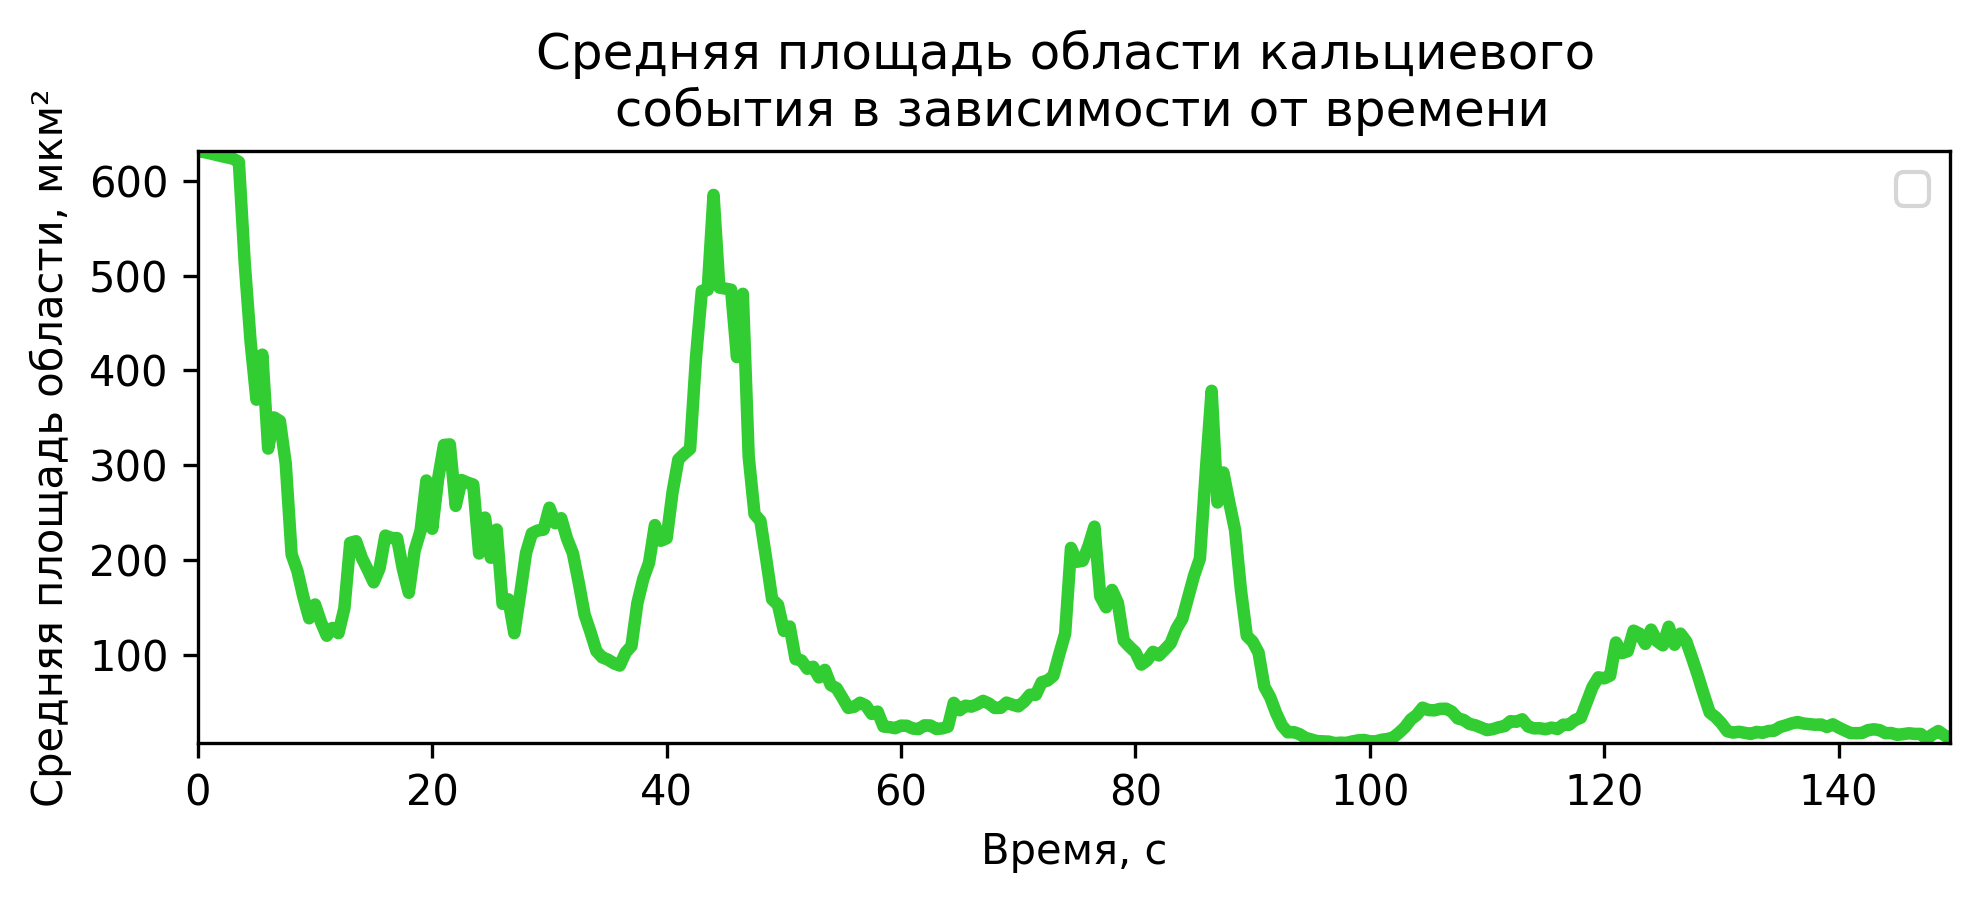

     time_seconds  average_area
0             0.0    631.268743
1             0.5    630.630527
2             1.0    629.323337
3             1.5    627.812380
4             2.0    626.339869
..            ...           ...
295         147.5     10.946339
296         148.0     15.502135
297         148.5     19.225939
298         149.0     14.901151
299         149.5     11.397860

[300 rows x 2 columns]


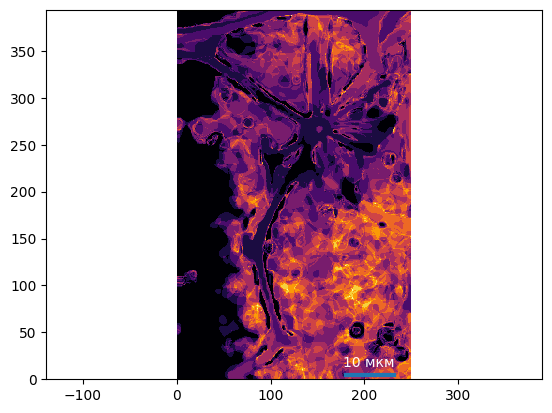

luminosity_level    11.297189
dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


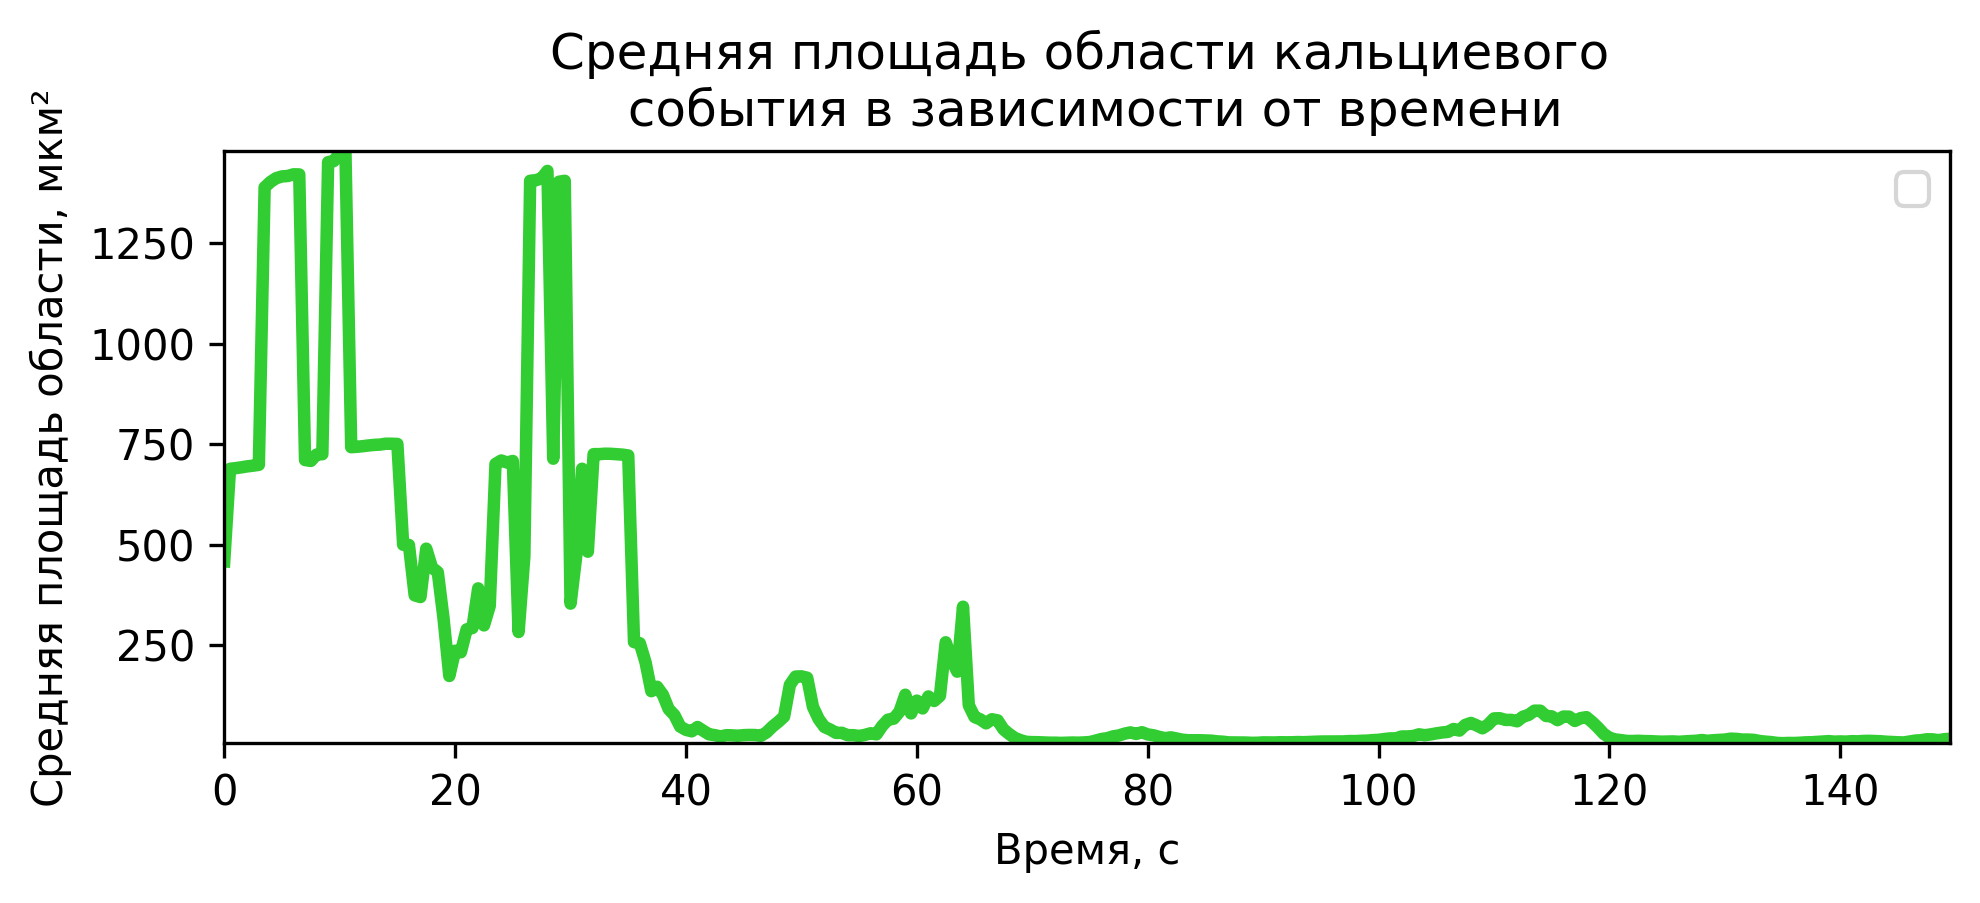

     time_seconds  average_area
0             0.0    458.592849
1             0.5    688.840830
2             1.0    690.522876
3             1.5    692.579777
4             2.0    694.934641
..            ...           ...
295         147.5     16.033577
296         148.0     15.796809
297         148.5     13.786196
298         149.0     16.220006
299         149.5     17.155167

[300 rows x 2 columns]


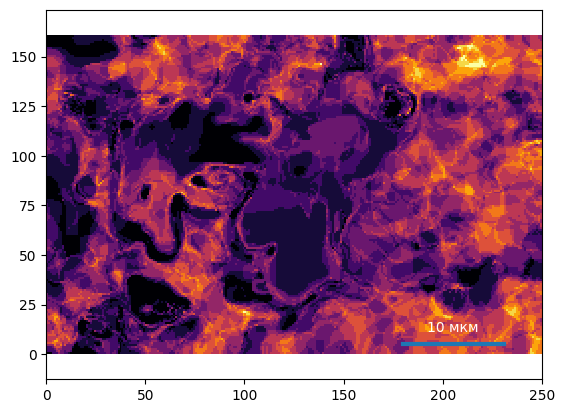

luminosity_level    15.739682
dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


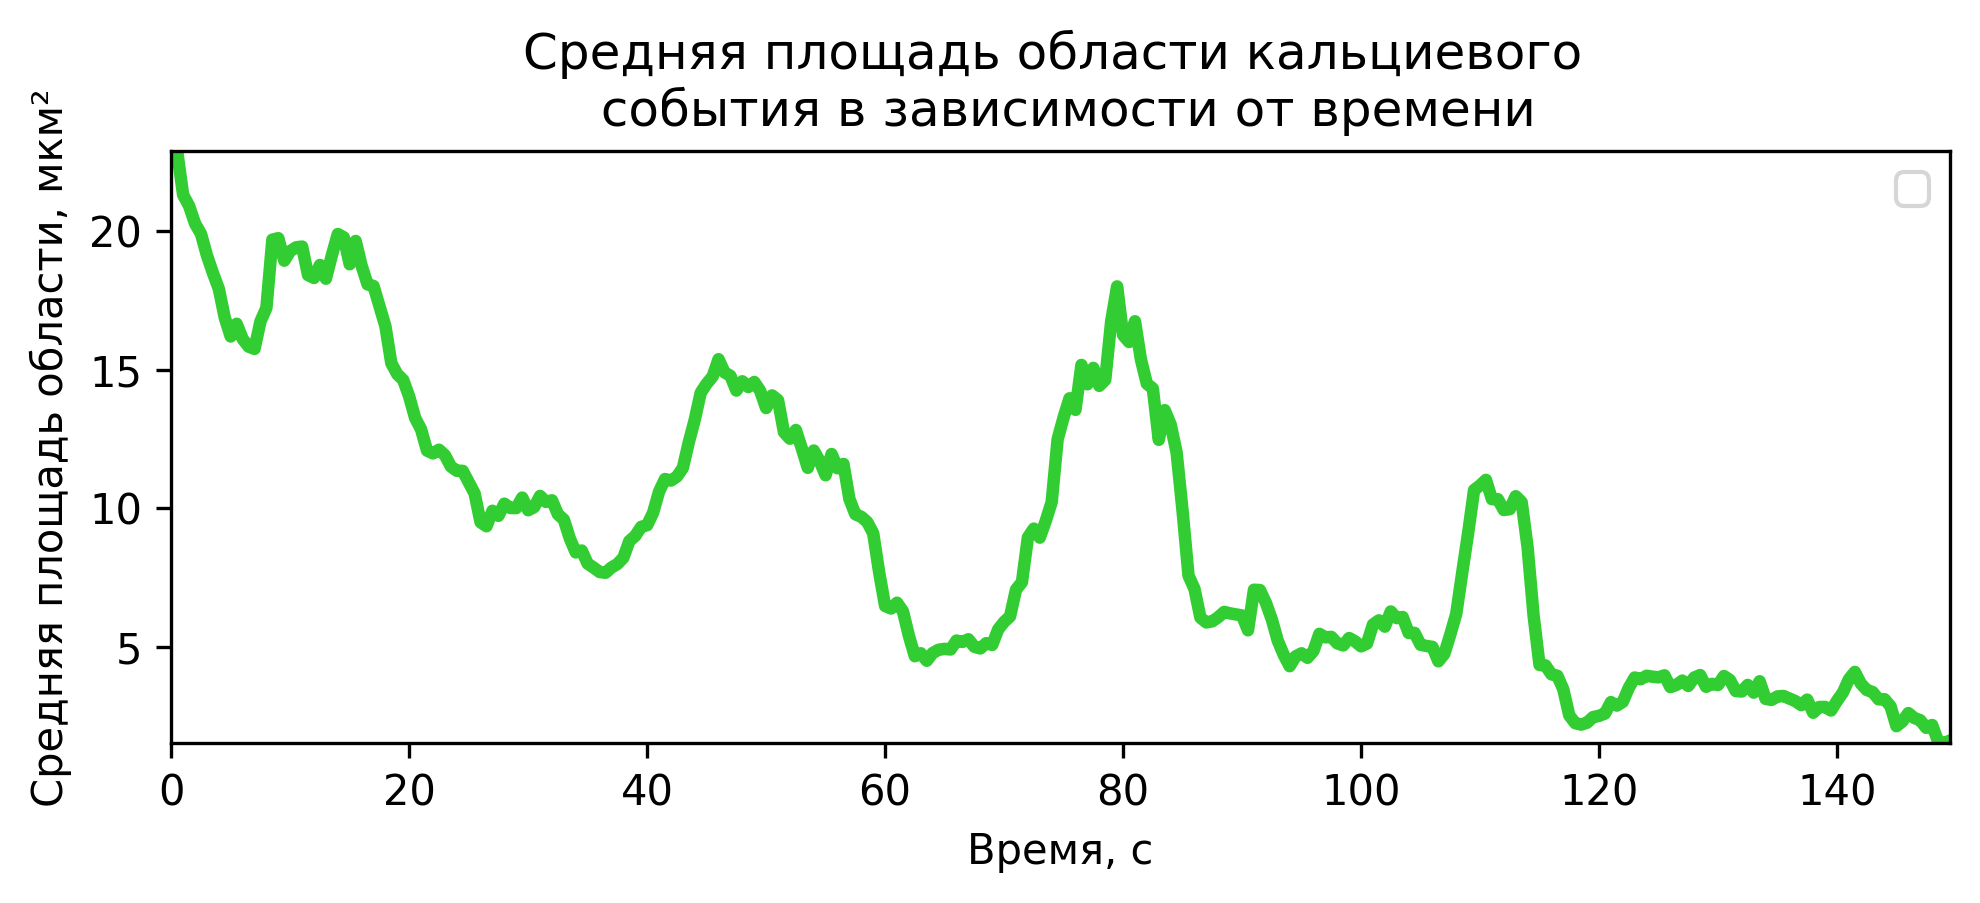

     time_seconds  average_area
0             0.0     22.645400
1             0.5     22.871812
2             1.0     21.304493
3             1.5     20.907886
4             2.0     20.272972
..            ...           ...
295         147.5      2.089196
296         148.0      2.190549
297         148.5      1.594704
298         149.0      1.536039
299         149.5      1.628928

[300 rows x 2 columns]


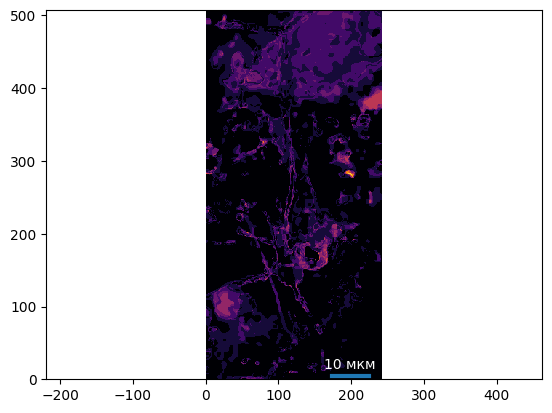

luminosity_level    101.02416
dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


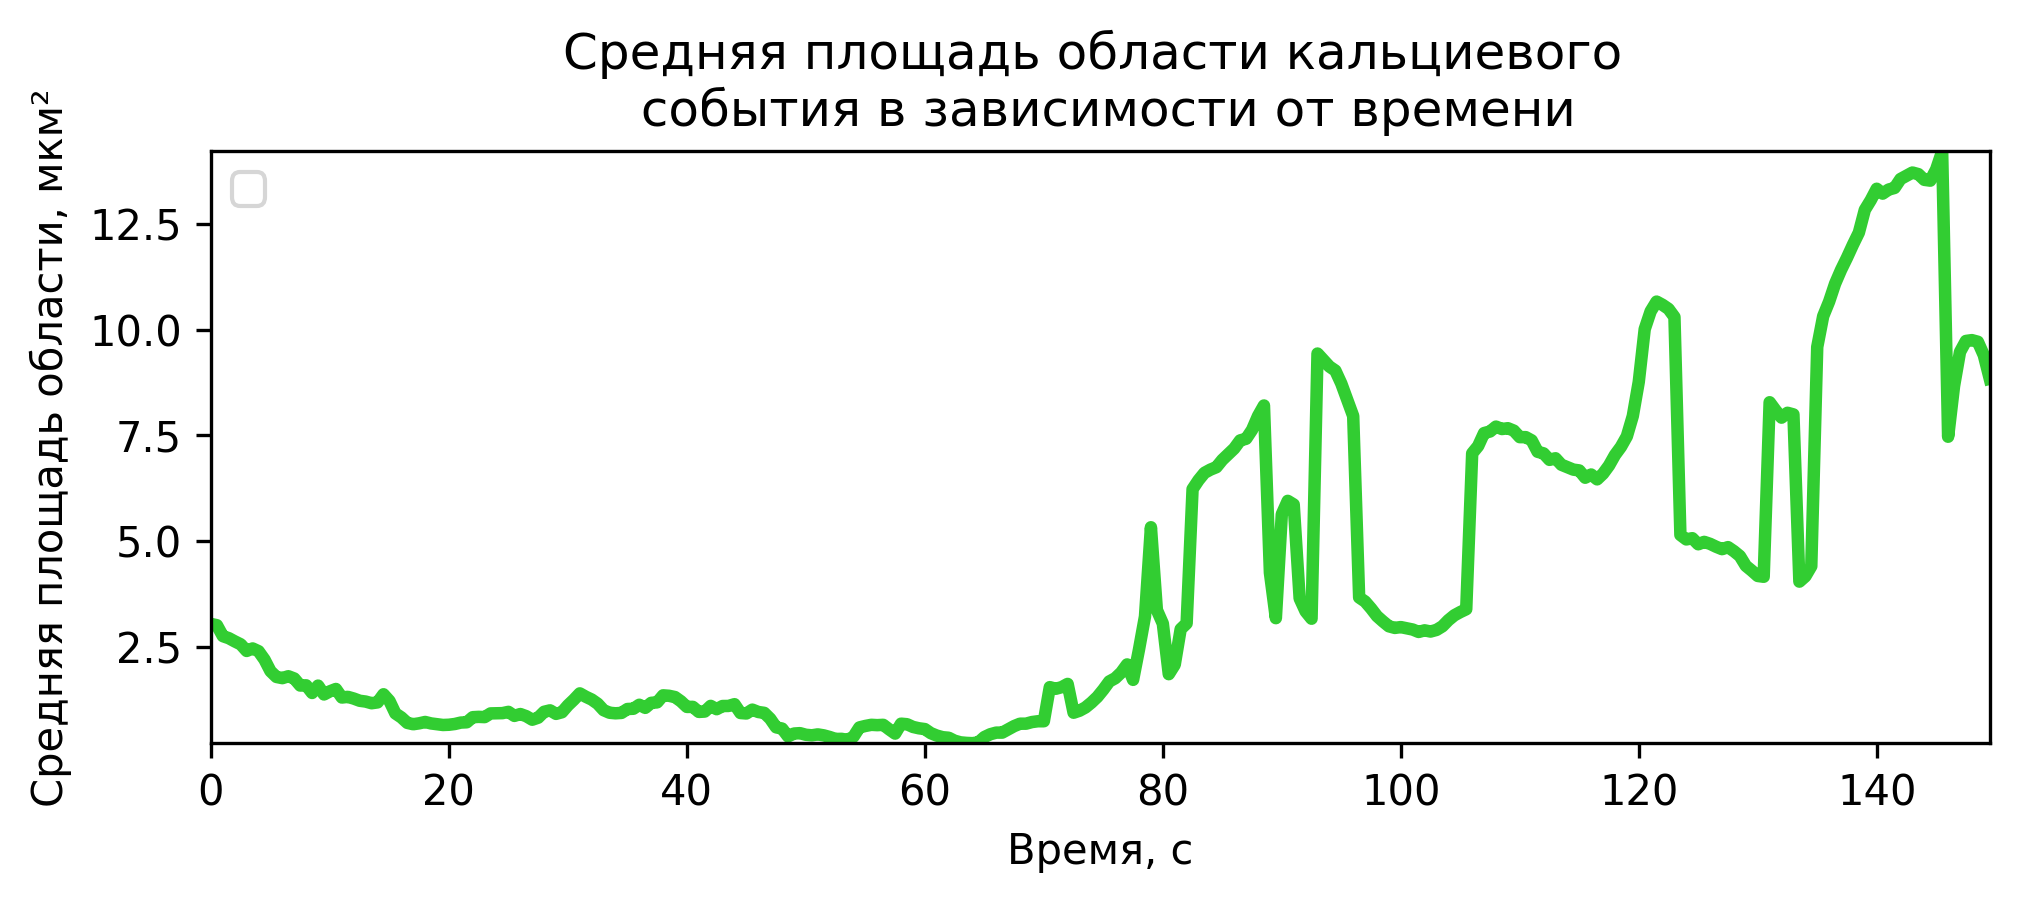

     time_seconds  average_area
0             0.0      3.035815
1             0.5      3.004022
2             1.0      2.746197
3             1.5      2.697452
4             2.0      2.621931
..            ...           ...
295         147.5      9.736640
296         148.0      9.755863
297         148.5      9.717416
298         149.0      9.400231
299         149.5      8.842753

[300 rows x 2 columns]


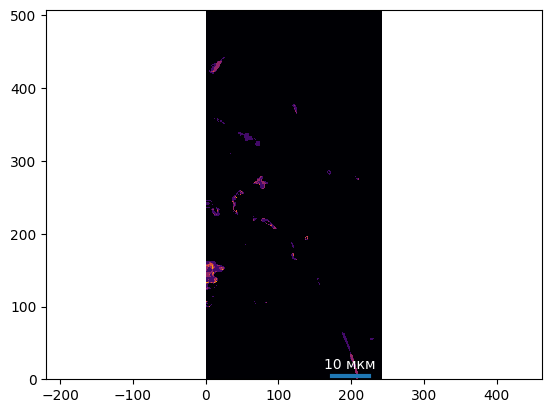

luminosity_level    176.381235
dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


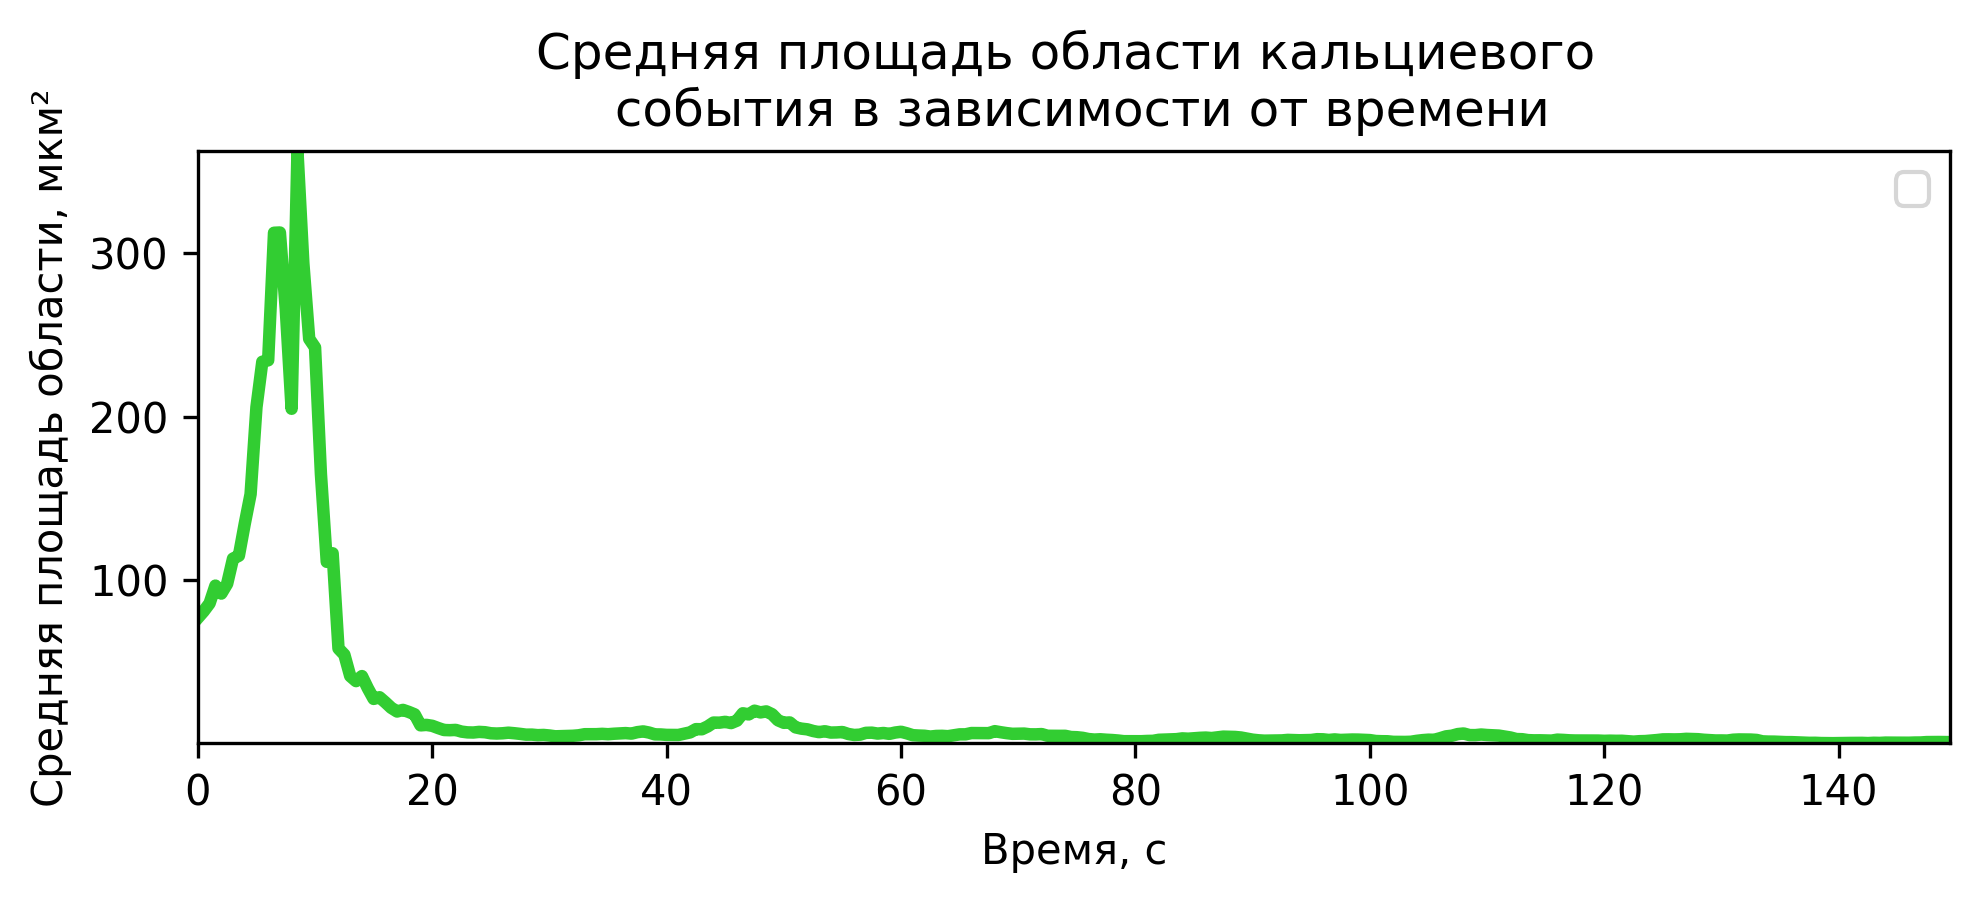

     time_seconds  average_area
0             0.0     77.159884
1             0.5     81.245675
2             1.0     86.038771
3             1.5     96.857543
4             2.0     92.008416
..            ...           ...
295         147.5      1.420782
296         148.0      1.450491
297         148.5      1.473210
298         149.0      1.438258
299         149.5      1.403306

[300 rows x 2 columns]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Кристина\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Кристина\AppData\Local\Temp\ipykernel_17952\58712767.py", line 2, in <module>
    function_all_functions(main_folder_path)
  File "C:\Users\Кристина\AppData\Local\Temp\ipykernel_17952\1086118559.py", line 17, in function_all_functions
    burning_times = count_burning_times(events_df)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Кристина\AppData\Local\Temp\ipykernel_17952\2367370909.py", line None, in count_burning_times
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Кристина\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

In [ ]:
main_folder_path = r"C:\Hw_prog\images"
function_all_functions(main_folder_path)

### Запуск при помощи модуля